<a href="https://colab.research.google.com/github/h-ueno2/intern_sample/blob/main/notebook/image_classification_cat_vs_dog_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ディープラーニングを使用した画像分類の実例

実際に、教師あり学習である画像分類を実践してみましょう！

今回はディープラーニングを用いて画像の分類を行います。  
テーマとしては画像分類の例としてよく扱われている猫と犬の画像を分類してみます。

<img src="https://drive.google.com/uc?export=view&
id=1945U_cs0jH9Hs0cLUQzCjMb5ACUZTGgH" width=80%>

## ライブラリのインポート

プログラムは一から全部自分で作るということはほとんどありません。  
基本的には`ライブラリ`という既に実装済みの部品を組み合わせたり設定を変えたりして使用します。


Pythonにおけるディープラーニングのライブラリとしては以下が有名です。
- TensorFlow
- PyTorch

今回の例ではTensorFlowを使用します。  

では、TensorFlowと必要なその他のライブラリをインポートしましょう。  

> **インポート**とは  
> ライブラリを自分の作っているプログラムで使用できるように読み込みする事を言います。


In [75]:
import os
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as display

import tensorflow as tf
from tensorflow.keras import utils as np_utils
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, MaxPooling2D

## 画像データの取得
今回使用するデータである犬と猫の画像を取得します。  
画像データはGoogleが公開している犬と猫の画像が分類済みのデータを使用します。  

In [76]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# zipファイルをダウンロードします。
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # 学習用の猫画像のディレクトリ
train_dogs_dir = os.path.join(train_dir, 'dogs')  # 学習用の犬画像のディレクトリ
validation_cats_dir = os.path.join(validation_dir, 'cats')  # 検証用の猫画像のディレクトリ
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # 検証用の犬画像のディレクトリ
print("==学習用=======")
print("　　猫画像のパス：", train_cats_dir)
print("　　犬画像のパス：", train_dogs_dir)
print("==検証用=======")
print("　　猫画像のパス：", validation_cats_dir)
print("　　犬画像のパス：", validation_dogs_dir)

==学習用=======
　　猫画像のパス： /root/.keras/datasets/cats_and_dogs_filtered/train/cats
　　犬画像のパス： /root/.keras/datasets/cats_and_dogs_filtered/train/dogs
==検証用=======
　　猫画像のパス： /root/.keras/datasets/cats_and_dogs_filtered/validation/cats
　　犬画像のパス： /root/.keras/datasets/cats_and_dogs_filtered/validation/dogs


このデータセットは以下のような分類の通りにディレクトリが分けられています。
- train : 教師データ。学習に使用するためのデータです。
  - cats
  - dogs
- validation : 検証データ。モデルの学習度合いを検証するためのデータです。
  - cats
  - dogs

では、それぞれの画像の数を確認してみましょう。

In [77]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

print("==学習用=======")
print('　　猫画像の数：', num_cats_tr)
print('　　犬画像の数：', num_dogs_tr)
print("==検証用=======")
print('　　猫画像の数', num_cats_val)
print('　　犬画像の数：', num_dogs_val)
print("==合計=======")
print("　　猫画像の数", total_train)
print("　　犬画像の数", total_val)

==学習用=======
　　猫画像の数： 1000
　　犬画像の数： 1000
==検証用=======
　　猫画像の数 500
　　犬画像の数： 500
==合計=======
　　猫画像の数 2000
　　犬画像の数 1000


一旦ここで、この後に使用するネットワークの学習用の定数を設定しておきます。

In [78]:
BATCH_SIZE = 128
IMG_SIZE = (160, 160)
IMG_SHAPE = IMG_SIZE + (3,)

# データの準備
先ほど取得した画像データを機械学習のプログラム上で扱いやすくするように準備します。  

次のセルでは以下のことを行っています。
1. 教師データと検証データのデータセットを作成します。
2. 検証データの一部について、学習後の精度評価用のテストデータとして抜き出します。

> **データセット**  
> この場でのデータセットとは、  
> データの集まりを機械学習の処理で扱いやすくするために機能を持たせた箱のような物をイメージするとわかりやすいかと思います。  
> 例えば以下のような機能があります。
> - 決められた数だけ画像を取り出す
> - 決められたサイズに画像を縮小する。
> - 取り出す画像をランダムにする。

In [79]:
# 教師データのデータセットを定義します。
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True, # ランダムにする
                                             batch_size=BATCH_SIZE, # 一度に処理する画像をBATCH_SIZE分とする。
                                             image_size=IMG_SIZE # 取り出すときの画像サイズをIMG_SIZEとする
                                            )
# 検証データのデータセットを定義します。
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

# 検証データの一部をテストデータとして使用します。
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5) # 検証データの1/5をテストデータに。
validation_dataset = validation_dataset.skip(val_batches // 5) # 残りを検証データとして再定義

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


試しに画像を表示してみます。  
教師データのデータセットからランダムに9枚の画像を表示しましょう。

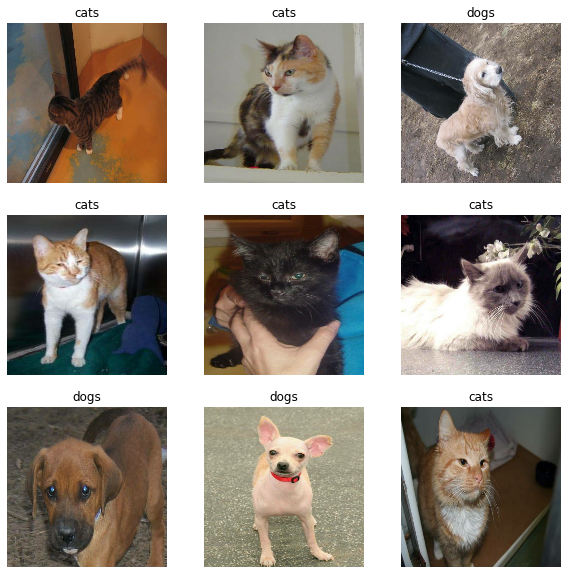

In [80]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10)) # 画像を表示するエリアを定義します。

for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1) # 画像の表示位置を設定
        plt.imshow(images[i].numpy().astype("uint8")) # 画像を表示
        plt.title(class_names[labels[i]]) # 画像のクラス（犬か猫か）を表示
        plt.axis("off") # 縦軸と横軸を非表示

## モデルの作成
それでは実際に画像を分類するモデルを作成してみましょう。

モデルの作成方法としては、ニューラルネットワークの層を一から定義する方法もありますが、  
実際の業務ではオープンソースとして公開されている構築済み/事前に学習済みのモデルをベースとすることが多いです。  
例えば、ベースとなったモデルに対し、解きたい問題（今回であれば犬と猫の分類）に合わせて
- 入出力を定義し直す。
  - 入力される画像サイズを定義する
  - 分類の数に合わせて出力する値を定義し直す
- 問題のデータで学習し直す

というやり方が基本になります。


今回は`MobileNetV2`というモデルをベースとして、犬と猫の分類用にモデルを定義しましょう。

In [81]:
def sample_model():
    """モデルを作成して返却する関数です。"""

    # ベースモデルを用意
    base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                   include_top=False,
                                                   weights='imagenet')
    base_model.trainable = False

    # モデル全体の構成を定義します。
    inputs = tf.keras.Input(shape=(160, 160, 3)) # 入力部分の定義
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs) # MobileNetV2用のデータ前処理
    x = base_model(x, training=False) # ベースのモデル
    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)

    # モデルのコンパイル
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

## モデルの学習

それでは作成したモデルを学習してみましょう。

モデルの学習はどのような事をしているかというと、
1. 学習データを入力として予測をします。
2. 学習データの予測結果と正解を比較し、損失(loss：間違いの度合）を計算します。
3. 損失が少なくなるようにモデルの中のパラメータを調整します。
4. 1～3を学習データ分繰り返します。

上記を学習データ全部に対して実施する事を1エポックといいます。  
※5エポックだと全ての学習データを5回使用して学習したという事になります。


`TensorFlow`というライブラリを使用した場合、  
上記のような学習の処理は`fit`というメソッド（関数）を実行するだけでできてしまいます。便利ですね！

In [82]:
# エポック（学習回数）
# ここの数字を変更すると学習回数も変更できます。
epochs = 5

# モデルを作成
model = sample_model()

# モデルの学習
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset)

Epoch 1/5
16/16 [==============================] - 11s 436ms/step - loss: 0.4286 - accuracy: 0.8230 - val_loss: 0.2117 - val_accuracy: 0.9622
Epoch 2/5
16/16 [==============================] - 7s 374ms/step - loss: 0.1601 - accuracy: 0.9610 - val_loss: 0.1162 - val_accuracy: 0.9759
Epoch 3/5
16/16 [==============================] - 7s 371ms/step - loss: 0.1091 - accuracy: 0.9690 - val_loss: 0.0917 - val_accuracy: 0.9759
Epoch 4/5
16/16 [==============================] - 7s 373ms/step - loss: 0.0888 - accuracy: 0.9730 - val_loss: 0.0756 - val_accuracy: 0.9794
Epoch 5/5
16/16 [==============================] - 7s 365ms/step - loss: 0.0777 - accuracy: 0.9770 - val_loss: 0.0702 - val_accuracy: 0.9828


セルを実行すると、進捗のバーと一緒に`loss`や`accuracy`という謎の英単語と数字が表示されました。  
これはそれぞれ何かというと、

- loss：損失関数。教師データを予測した結果の誤り度合い。0に近いほど良い。
- accuracy：精度。教師データを予測した結果の精度。1に近づくほど良い。
- val_loss：検証データを予測した結果の損失関数。
- val_accuracy：検証データを予測した結果の精度。

先ほども触れたようにモデルの学習は教師データの損失関数を小さくするようにパラメータを調整しています。  
なので、学習のエポックが進むと`loss`が減少し、`accuracy`も向上していると思います。  


ただ、実際に学習したモデルを業務やサービスで使用する本番では、  
学習データには存在しない未知のデータに対しての予測を行う必要があります。  
未知のデータに対するモデルの性能の事を**汎化性能**と呼びます。

汎化性能を測るために、教師データとは別の`検証データ`を使用して損失関数と精度を算出しています。  
※これが`val_loss`と`val_accuracy`になります。



では、学習結果がどのように推移したのか、わかりやすいようにグラフで可視化してみましょう。



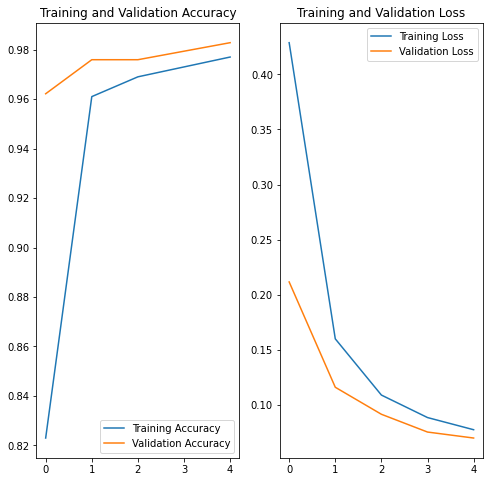

In [83]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

左のグラフが精度、右のグラフが損失を示しています。  
横軸がエポックになります。  
※グラフで日本語を表示させようとすると色々設定が必要になってしまうのでご了承ください。


グラフを見ますとエポックが進むにつれて、教師データ/検証データのどちらも精度は上がり損失が減少している事が確認できるかと思います。


では、このままエポックの数を大きくするともっとデータの精度はよくなるでしょうか？  
時間が余ったら試してみましょう。



# モデルの評価

では最終的なモデルの精度を評価してみましょう。

モデルの評価を行うには教師データ、検証データとは別に用意していたテストデータセットを使用します。

モデルの`evaluate`関数に対してテストデータを渡します。  
そうするとテストデータに対して分類予測した結果の精度を算出してくれます。


In [84]:
# test_datasetを使用してmodelの評価をします。
loss, accuracy = model.evaluate(test_dataset)
print('テストデータセットでの精度 :', accuracy)

1/1 [==============================] - 1s 1s/step - loss: 0.0453 - accuracy: 1.0000
テストデータセットでの精度 : 1.0


今回はベースのモデルに`MobileNetV2`を使用したこともあり、非常に高い結果になったかと思われます。

では実際に予測結果を確認してみましょう。  
今回、実際の予測結果は0～1の間の少数として出力されます。  
これは
- 0に近いと猫
- 1に近いと犬

という事を表しています。


ただ、それだと確認が困難なため、`0.5`を閾値として分類しています。

In [85]:
# テストデータセットから画像データとラベルを取得
image_batch, label_batch = test_dataset.as_numpy_iterator().next()

# モデルに画像データを渡して予測をする
predictions = model.predict_on_batch(image_batch).flatten()

# 予測結果を確認
print('予測結果：\n', predictions)

# 0.5を閾値として0と1に分類
predictions = tf.where(predictions < 0.5, 0, 1).numpy()

# 予測結果を表示
print('='*30)
print('予測結果:\n', predictions)
print('='*30)
print('正解のラベル:\n', label_batch)

予測結果：
 [9.88833547e-01 9.85774159e-01 4.14570607e-03 2.73210090e-03
 9.63779569e-01 7.97333300e-01 9.71958935e-01 6.62859902e-02
 2.14743242e-03 3.49989219e-04 7.28890486e-03 8.82235944e-01
 8.11390698e-01 8.82603049e-01 9.87148702e-01 2.07809987e-03
 3.01978178e-03 4.93882690e-04 2.00142693e-02 9.42315732e-04
 5.87133039e-03 9.90360975e-01 7.19566941e-01 5.46903466e-04
 9.97745335e-01 3.96299129e-03 3.28199379e-03 1.18554616e-02
 5.66901546e-03 9.90571856e-01 9.93032098e-01 9.95394349e-01
 9.66494554e-04 9.88167584e-01 3.49165552e-04 3.86139331e-03
 9.29121822e-02 8.23360324e-01 3.05988011e-04 9.95501935e-01
 4.07256857e-02 9.13211346e-01 9.92329180e-01 1.74600966e-02
 1.07073123e-04 8.98228679e-03 1.26061454e-01 2.88842712e-03
 8.12328830e-02 1.76923396e-03 9.36838567e-01 9.78725135e-01
 6.21281052e-03 1.46403722e-02 7.24669173e-03 9.92991328e-01
 9.95750308e-01 9.89875972e-01 9.94854271e-01 9.71874774e-01
 2.45843269e-03 1.12244375e-02 1.56158127e-03 6.26023801e-04
 3.09127592e-03 9

数字だけですとイメージが付かないため、試しに画像を表示してみましょう。

正解した画像


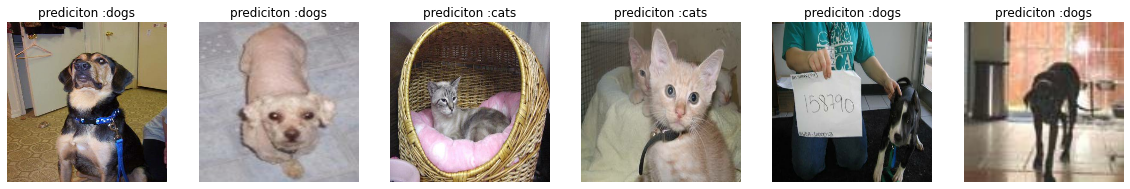

失敗した画像


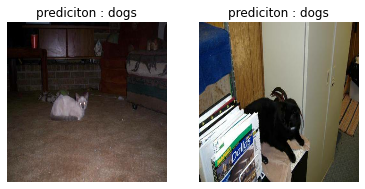

In [114]:
success = [] # 正解
error = [] # 失敗

for i in range(len(label_batch)):
    result = {
        'image': image_batch[i],
        'label': label_batch[i],
        'pred': predictions[i]
    }
    if predictions[i] == label_batch[i]:
        success.append(result)
    else:
        error.append(result)

# 試しに最大6枚ずつ表示します。
plt.figure(figsize=(20,10))
print("正解した画像")
for i in range(6):
    if i >= len(success):
        break
    ax = plt.subplot(1, 6, i + 1)
    plt.imshow(success[i]['image'].astype("uint8"))
    plt.title("prediciton :" + class_names[success[i]['pred']])
    plt.axis("off")

plt.show()
plt.figure(figsize=(20,10))
print("失敗した画像")
for i in range(6):
    if i >= len(error):
        break
    ax = plt.subplot(1, 6, i + 1)
    plt.imshow(error[i]['image'].astype("uint8"))
    plt.title("prediciton : " + class_names[error[i]['pred']])
    plt.axis("off")
plt.show()

試しに好きな画像を用いて予測してみましょう。

1. 何か画像ファイルをダウンロードします。
  1. 拡張子がJPEG, PNG, GIF, BMPのいずれか
2. Google Colaboratoryの画面の左側のメニューよりファイルタブを表示します。
3. ダウンロードした画像をファイルタブにドラッグ&ドロップします。  
   この時ダイアログが表示されますが気にせずOKを押してください。
<img src="https://drive.google.com/uc?export=view&
id=1QyKLKB7d79YANIb7q2myFY56ODxl5UJr" width=80%>

以下のセルの変数`file_name`を先ほどドラッグ&ドロップした画像ファイル名に書き換えて実行してください。
そうすると自分の選んだ画像について予測した結果を表示することができます。




(-0.5, 159.5, 159.5, -0.5)

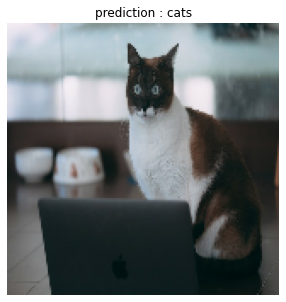

In [124]:
# 画像のファイル名
file_name = "neko.jpg" # ここのファイル名を自分が予測したい画像のファイル名に変更してください

# 画像の行列化
img_raw = tf.io.read_file(file_name)
img_tensor = tf.image.decode_image(img_raw)
# 画像のリサイズ
img_resize = tf.image.resize(img_tensor, IMG_SIZE)
img = (np.expand_dims(img_resize,0))
img.shape

# 予測
prediction = model.predict(img)
prediction = 0 if prediction < 0.5 else 1

plt.figure(figsize=(5, 5))
plt.imshow(img[0].astype("uint8"))
plt.title("prediction : " + class_names[prediction])
plt.axis("off")